In [21]:
sdss_general_path = "/media/lrikozavr/0402A64D02A64390/Users/lrik/Work/"
sdss_filename_fits = "specObj-dr17.fits"
sdss_filename_origin = f"{sdss_general_path}sdssdr17.csv"
sdss_filename_class_sample = f"{sdss_general_path}SDSS.csv"

In [3]:
import wget
sdssdr17_url = "https://data.sdss.org/sas/dr17/sdss/spectro/redux/specObj-dr17.fits"
wget.download(sdssdr17_url, 'specObj-dr17.fits')

'C:\\Users\\lrik\\Work\\specObj-dr17.fits'

In [1]:
import pandas as pd
import numpy as np
import os

from network import NN
from data_process import data_preparation, get_features

2024-04-23 05:59:35.927762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
from astropy.io import fits
fits_file = fits.open(sdss_filename_fits)
hdr = fits_file[1].header
#['SURVEY' 'PLATEQUALITY' 'SOURCETYPE' 'PLUG_RA' 'PLUG_DEC' 'CLASS' 'SUBCLASS' 'Z' 'Z_ERR' 'ZWARNING' 'Z_NOQSO' 'Z_ERR_NOQSO' 'ZWARNING_NOQSO' 'CLASS_NOQSO' 'SUBCLASS_NOQSO']
columns = [hdr[14],hdr[19],hdr[50],hdr[80],hdr[81],hdr[82],hdr[83],hdr[84],hdr[85],hdr[103],hdr[135],hdr[136],hdr[137],hdr[138],hdr[139]]
#ax1_count = hdr[3]
ax2_count = hdr[4] #count
data = fits_file[1].data
f = open(sdss_filename_origin,"w")
f.write(','.join(columns) + "\n")
for i in range(int(ax2_count)):
	f.write(f"{str(data[i][0])},{str(data[i][5])},{str(data[i][36])},{str(data[i][66])},{str(data[i][67])},{str(data[i][68])},{str(data[i][69])},{str(data[i][70])},{str(data[i][71])},{str(data[i][89])},{str(data[i][121])},{str(data[i][122])},{str(data[i][123])},{str(data[i][124])},{str(data[i][125])}\n")
f.close()
fits_file.close()

del data, f, fits_file, i, columns, ax2_count #ax1_count

In [28]:
data = pd.read_csv(sdss_filename_origin, header=0, sep=",")

/tmp/ipykernel_53468/3876214978.py:1: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(sdss_filename_origin, header=0, sep=",")


<h1>PreClassification<h1>

Classification

In [29]:
class_name_column = "class_name"

data.loc[(data["CLASS"] == "QSO") & ((data["SUBCLASS"].str.contains("STAR", na=True)) | (data["SUBCLASS"] == "BROADLINE")), class_name_column] = "qso"
#
data.loc[((data["CLASS"] == "QSO") | (data["CLASS"] == "GALAXY")) & (data["SUBCLASS"].str.contains("AGN", na=False)), class_name_column] = "agn"
#
data.loc[(data["CLASS"] == "GALAXY") & (data["SUBCLASS"].str.contains("STARBURST", na=False)), class_name_column] = "sbg"
#
data.loc[(data["CLASS"] == "GALAXY") & (data["SUBCLASS"].str.contains("STARFORMING", na=False)), class_name_column] = "sfg"
#
data.loc[(data["CLASS"] == "GALAXY") & ((data["SUBCLASS"].str.contains("NaN",na=True) | (data["SUBCLASS"] == "BROADLINE"))), class_name_column] = "gal"
#
data.loc[data["CLASS"] == "STAR", class_name_column] = "star"


In [30]:
data = data.rename(columns={"PLUG_RA": "RA", "PLUG_DEC": "DEC", "Z": "z", "Z_ERR": "z_err"})

Redshift cut off

In [31]:
data = data[(data["ZWARNING"] == 0) & (0.1 > abs(data["z_err"]/data["z"])) & (data["z"] <= 4.0)]

In [32]:
data = data.sort_values(by=["DEC"], ascending=True)
data

,SURVEY,PLATEQUALITY,SOURCETYPE,RA,DEC,CLASS,SUBCLASS,z,z_err,ZWARNING,Z_NOQSO,Z_ERR_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,class_name
1609086,segue1,good,NONLEGACY,7.715366,-19.702714,STAR,F5,0.000248,0.000022,0,0.0,0.0,0,NaN,NaN,star
1609083,segue1,good,NONLEGACY,7.679973,-19.641483,STAR,F5,-0.000613,0.000022,0,0.0,0.0,0,NaN,NaN,star
1609048,segue1,good,NONLEGACY,8.139904,-19.639879,STAR,G2,-0.000164,0.000014,0,0.0,0.0,0,NaN,NaN,star
1609043,segue1,good,NONLEGACY,8.163993,-19.615857,STAR,A0,0.000249,0.000010,0,0.0,0.0,0,NaN,NaN,star
1609205,segue1,good,NONLEGACY,7.132664,-19.603615,STAR,F9,-0.000164,0.000009,0,0.0,0.0,0,NaN,NaN,star
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451450,segue1,good,NONLEGACY,98.019854,84.791898,STAR,F5,-0.000761,0.000009,0,0.0,0.0,0,NaN,NaN,star
1455880,segue1,good,NONLEGACY,97.666877,84.793093,STAR,F2,-0.000391,0.000023,0,0.0,0.0,0,NaN,NaN,star
1451418,segue1,good,NONLEGACY,92.883648,84.794836,STAR,F9,-0.000158,0.000009,0,0.0,0.0,0,NaN,NaN,star
1455809,segue1,good,NONLEGACY,94.478598,84.837773,STAR,F9,-0.000321,0.000017,0,0.0,0.0,0,NaN,NaN,star


In [33]:
data.to_csv(sdss_filename_class_sample, index=False)

In [34]:
del class_name_column

<h1>MAIN</h1>

In [2]:
import json

class Config():

    def __init__(self,fconfig):
        config = json.load(fconfig)
        self.name_main_sample = config['name_sample']
        self.name_sample = config['name_sample'] + config['additional_name']
        self.general_path = config['general_path']
        self.data_path = config['data_path']
        self.prediction_path = config['prediction_path']
        self.test_path = config['test_path'] ############
        self.flags = config['flags']
        self.hyperparam = config['hyperparam']
        self.features = config['features']
        self.name_class = config['name_class']
        self.name_class_column = config["name_class_column"]
        self.base = config["base"]
        self.picture = config['picture']
        self.statistic = config['statistic']
        #
        self.path_ml_data = f'{self.general_path}/ml/data'
        self.path_ml = f'{self.general_path}/ml'
        self.path_sample = f'{self.general_path}/sample'
        self.path_pic = f'{self.general_path}/ml/picture'
        self.path_stat = f'{self.general_path}/statistic'
        #
        self.path_model = f"{self.path_ml}/model/mod_{self.name_sample}"
        self.path_weight = f"{self.path_ml}/model/weight_{self.name_sample}"
        self.path_eval = f"{self.path_ml}/eval/{self.name_sample}"
        self.path_predict = f"{self.path_ml}/prediction/{self.name_sample}"
        #
        columns = []
        columns_prob = []
        for col in self.name_class:
            columns.append(f"{col}_cls")
            columns_prob.append(f"{col}_cls_prob")
        self.name_class_cls = columns
        self.name_class_prob = columns_prob

<h1>Read config<h1>

In [13]:
fconfig = open('config_agn_sdss.json')
config = Config(fconfig)
fconfig.close()
del fconfig

<h1>Create file system<h1>

In [5]:
def dir(save_path,name):
    dir_name = f"{save_path}/{name}"
    if not os.path.isdir(dir_name):
        os.mkdir(dir_name)

if not os.path.isdir(config.general_path):
    os.mkdir(config.general_path)

dir(config.general_path,'sample')
dir(config.general_path,'statistic')
dir(config.general_path,'ml')
dir(config.path_ml,'data')
dir(config.path_ml,'model')
dir(config.path_ml,'eval')
dir(config.path_ml,'prediction')
dir(config.path_ml,'picture')

<h1>Downloading&Cross-match<h1>

In [37]:
from data_download import Download
config_base = dict(name_class=config.name_class,
                   base=config.base,
                   features=config.features["data"],
                   path_sample=config.path_sample)
#print(config_base["features"])
dow = Download(config_spec=config.flags["data_downloading"],config_base=config_base)

In [38]:
dow.diff_class(config.data_path,config.name_class_column)

qso 		 942881.0
agn 		 36172.0
sbg 		 99385.0
sfg 		 287806.0
gal 		 2444919.0
star 		 443269.0


In [39]:
dow.all_class_download(config.path_stat)

del dow

cut to slice start for  /home/lrikozavr/ML_work/agn_sdss/sample/qso_origin.csv
Origin catalog columns:	 ['RA', 'DEC', 'z', 'z_err']
cut to slice finish with  9  slices
total count of lines is  942881
/home/lrikozavr/ML_work/agn_sdss/sample/qso_origin/0_catwise.csv
{'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
[1, 2, 3, 4, 0, 15, 31, 32, 17, 33, 34, 35, 36, 37, 38]

/home/lrikozavr/ML_work/agn_sdss/sample/qso_origin/1_catwise.csv
{'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPma

<h1>["PM","Plx","e_Plx","RUWE","pscol"] saga</h1>

Null value visualisation

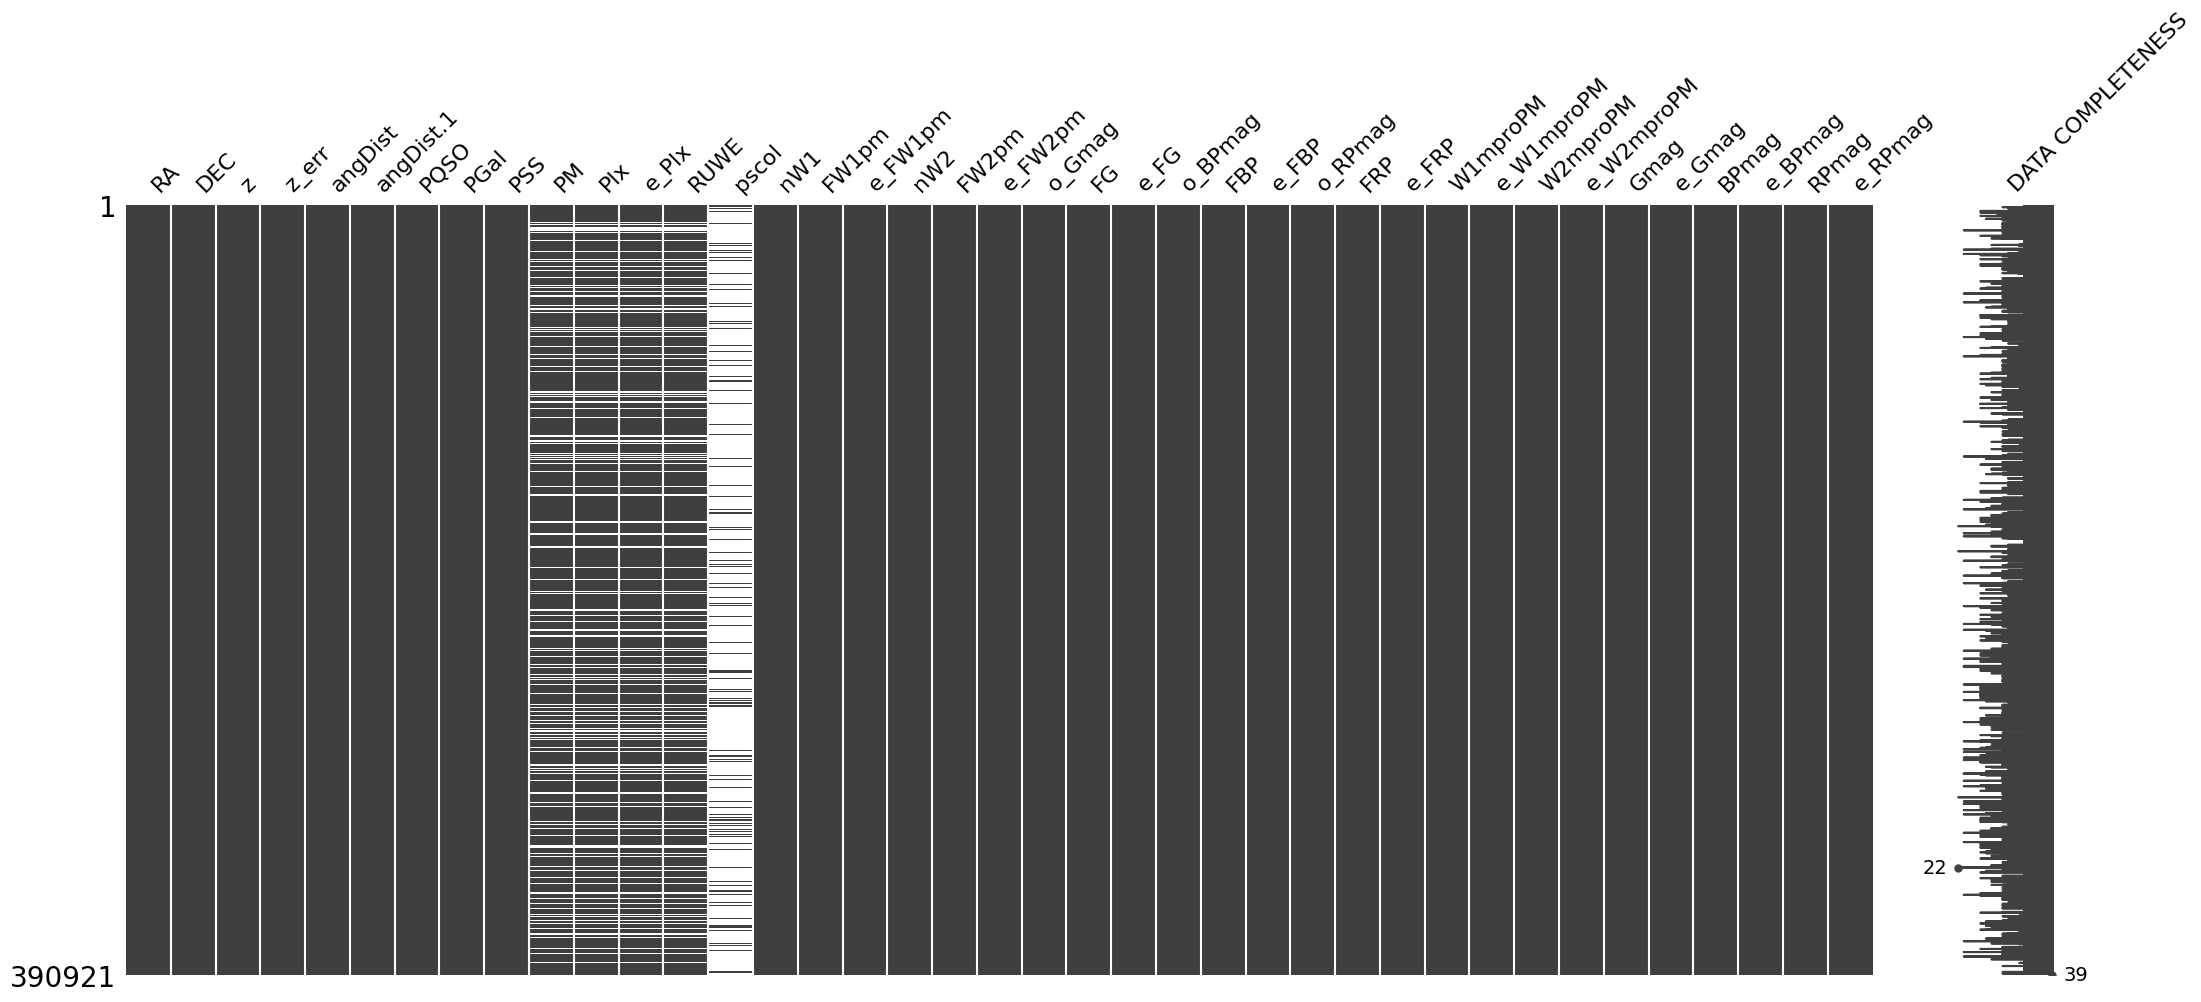

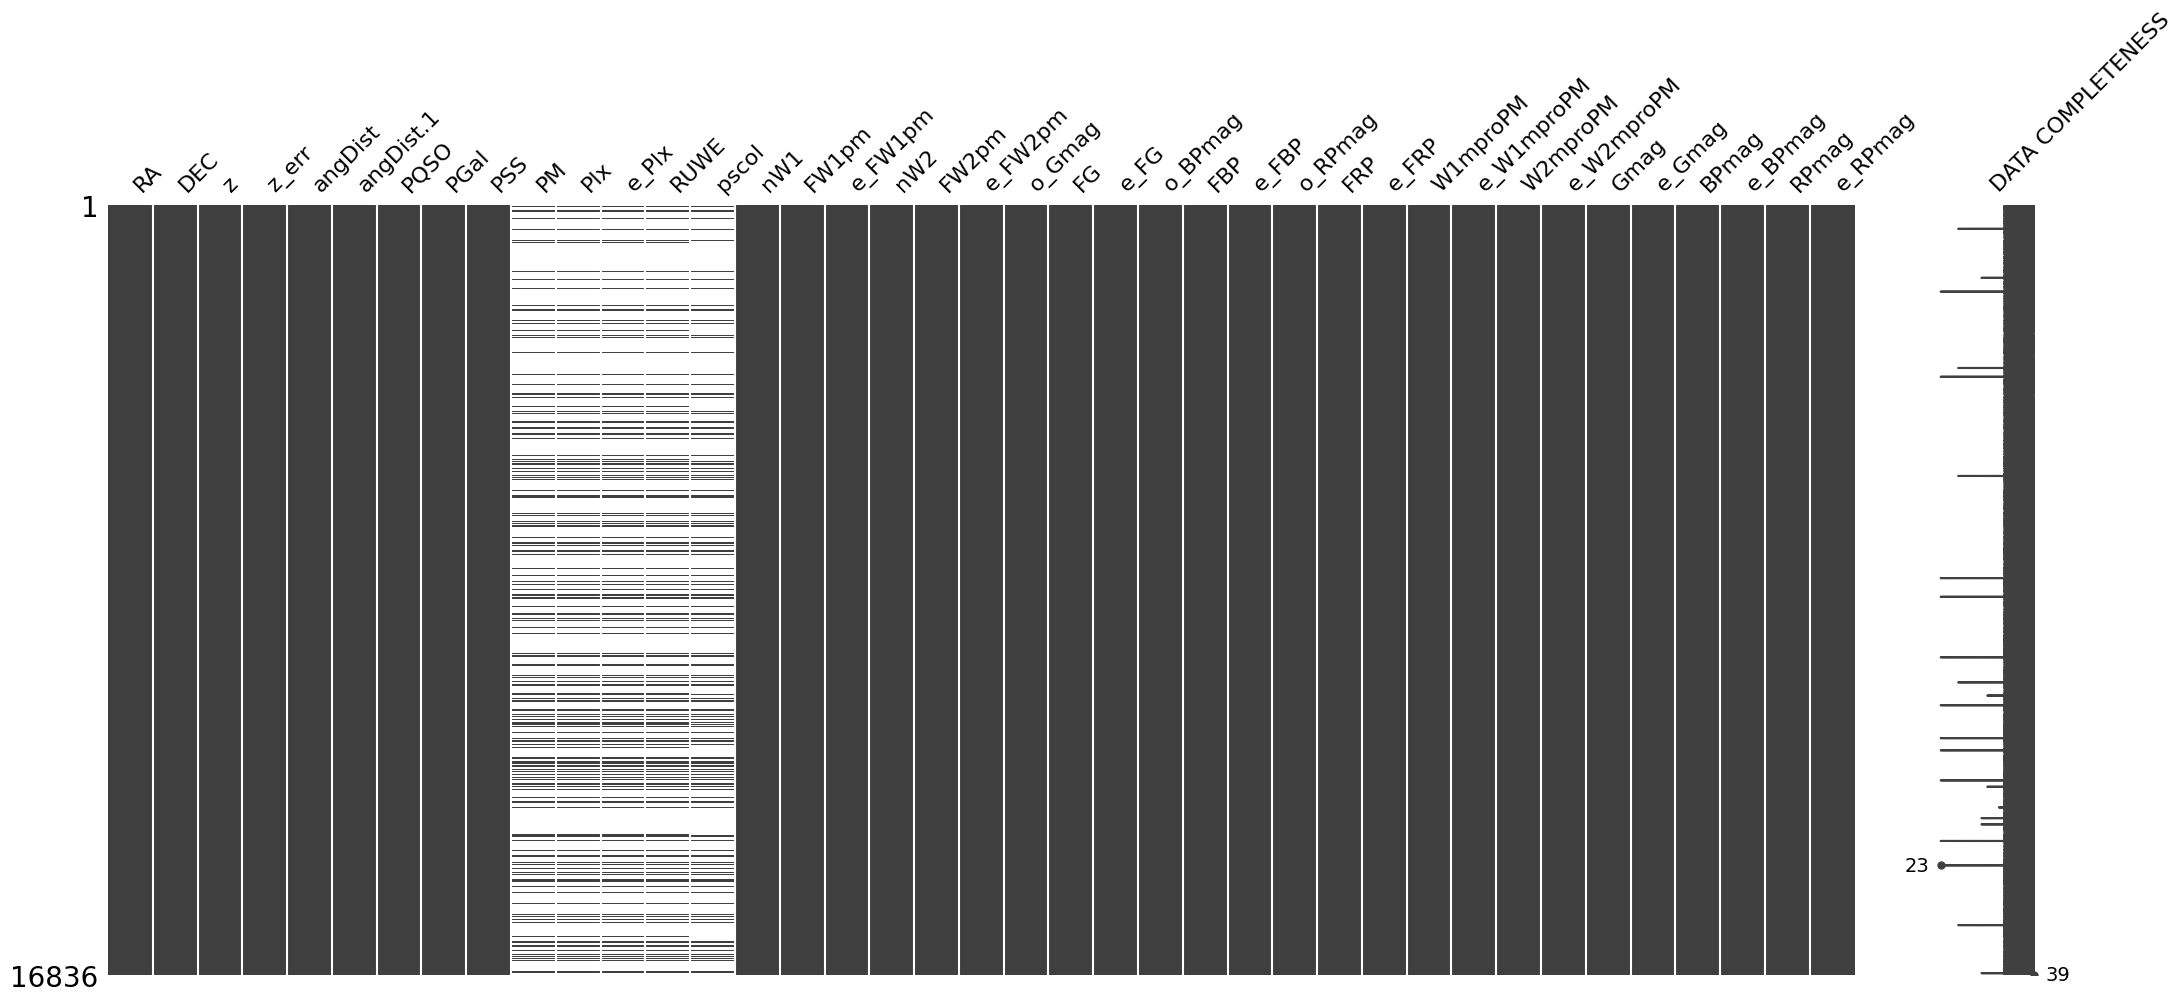

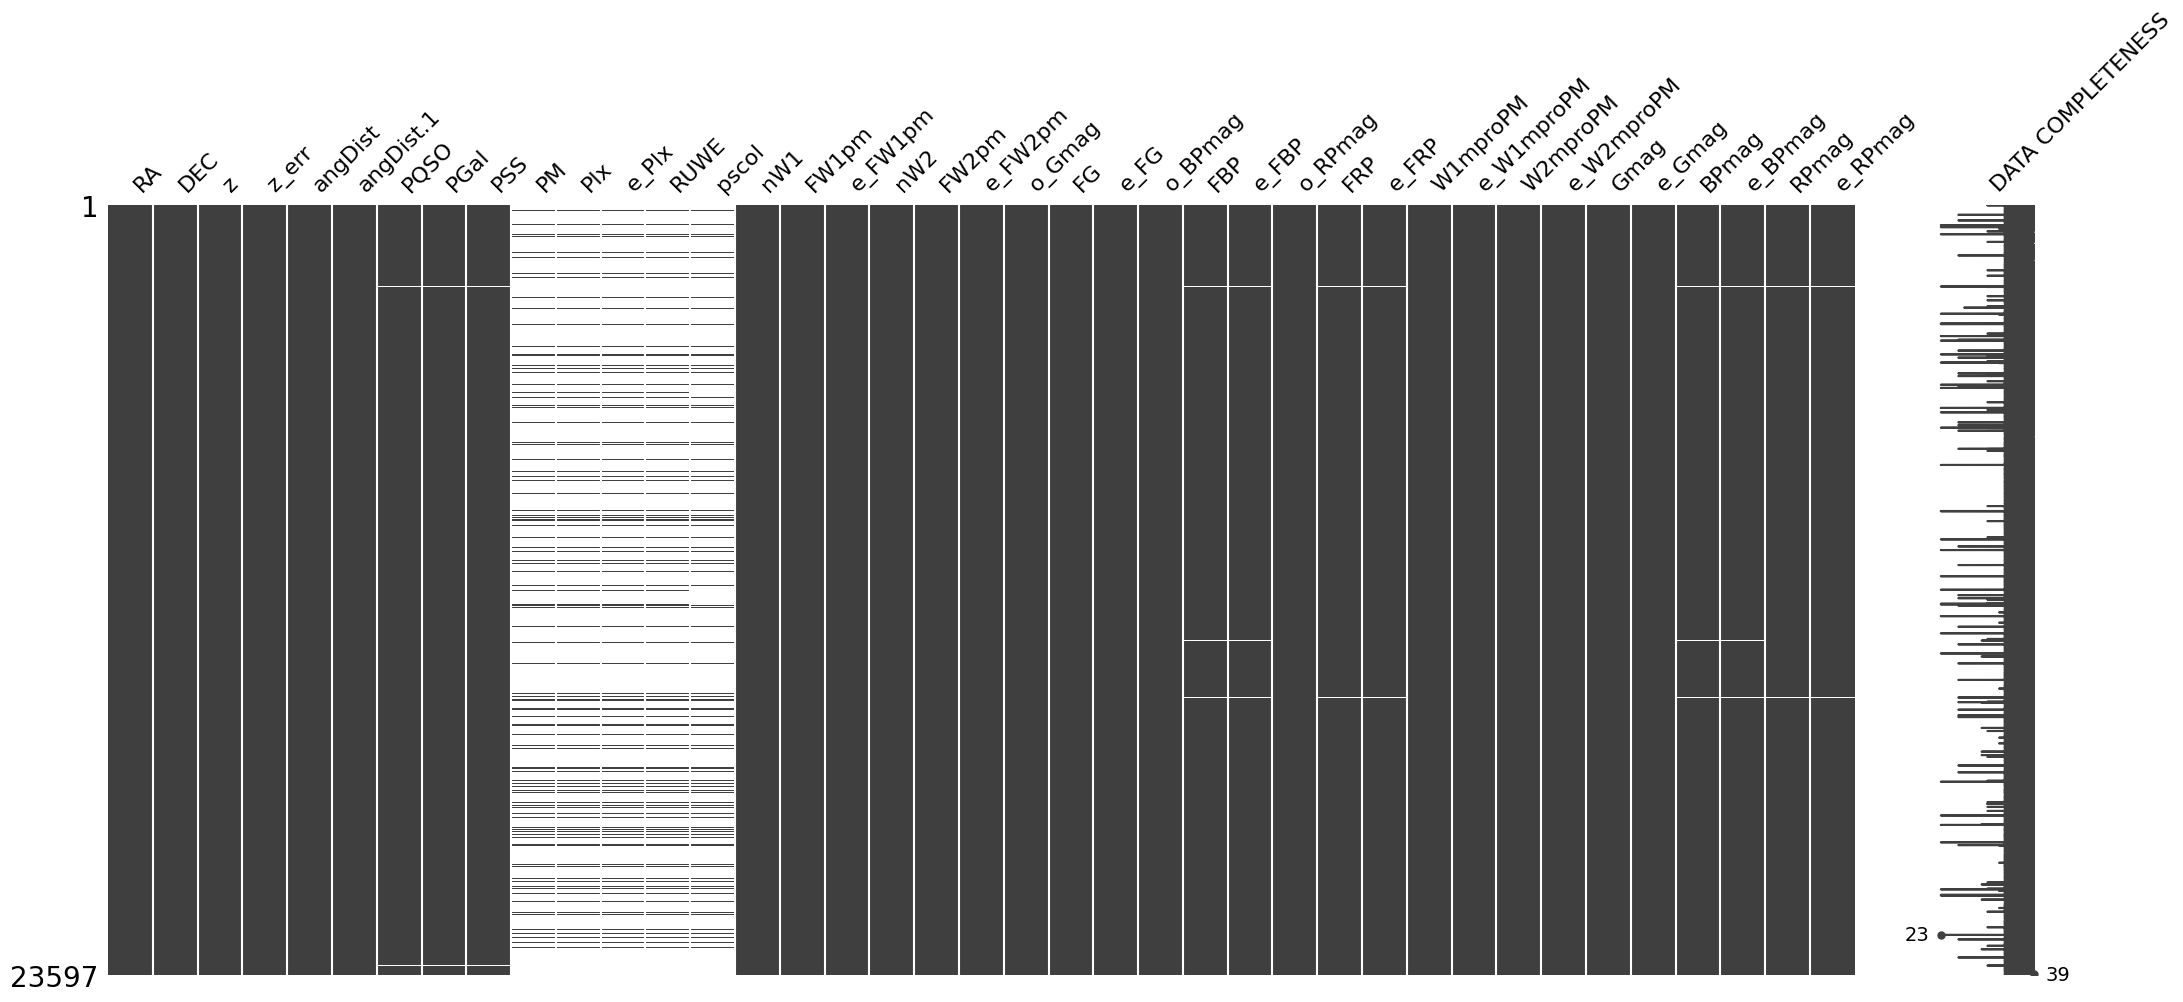

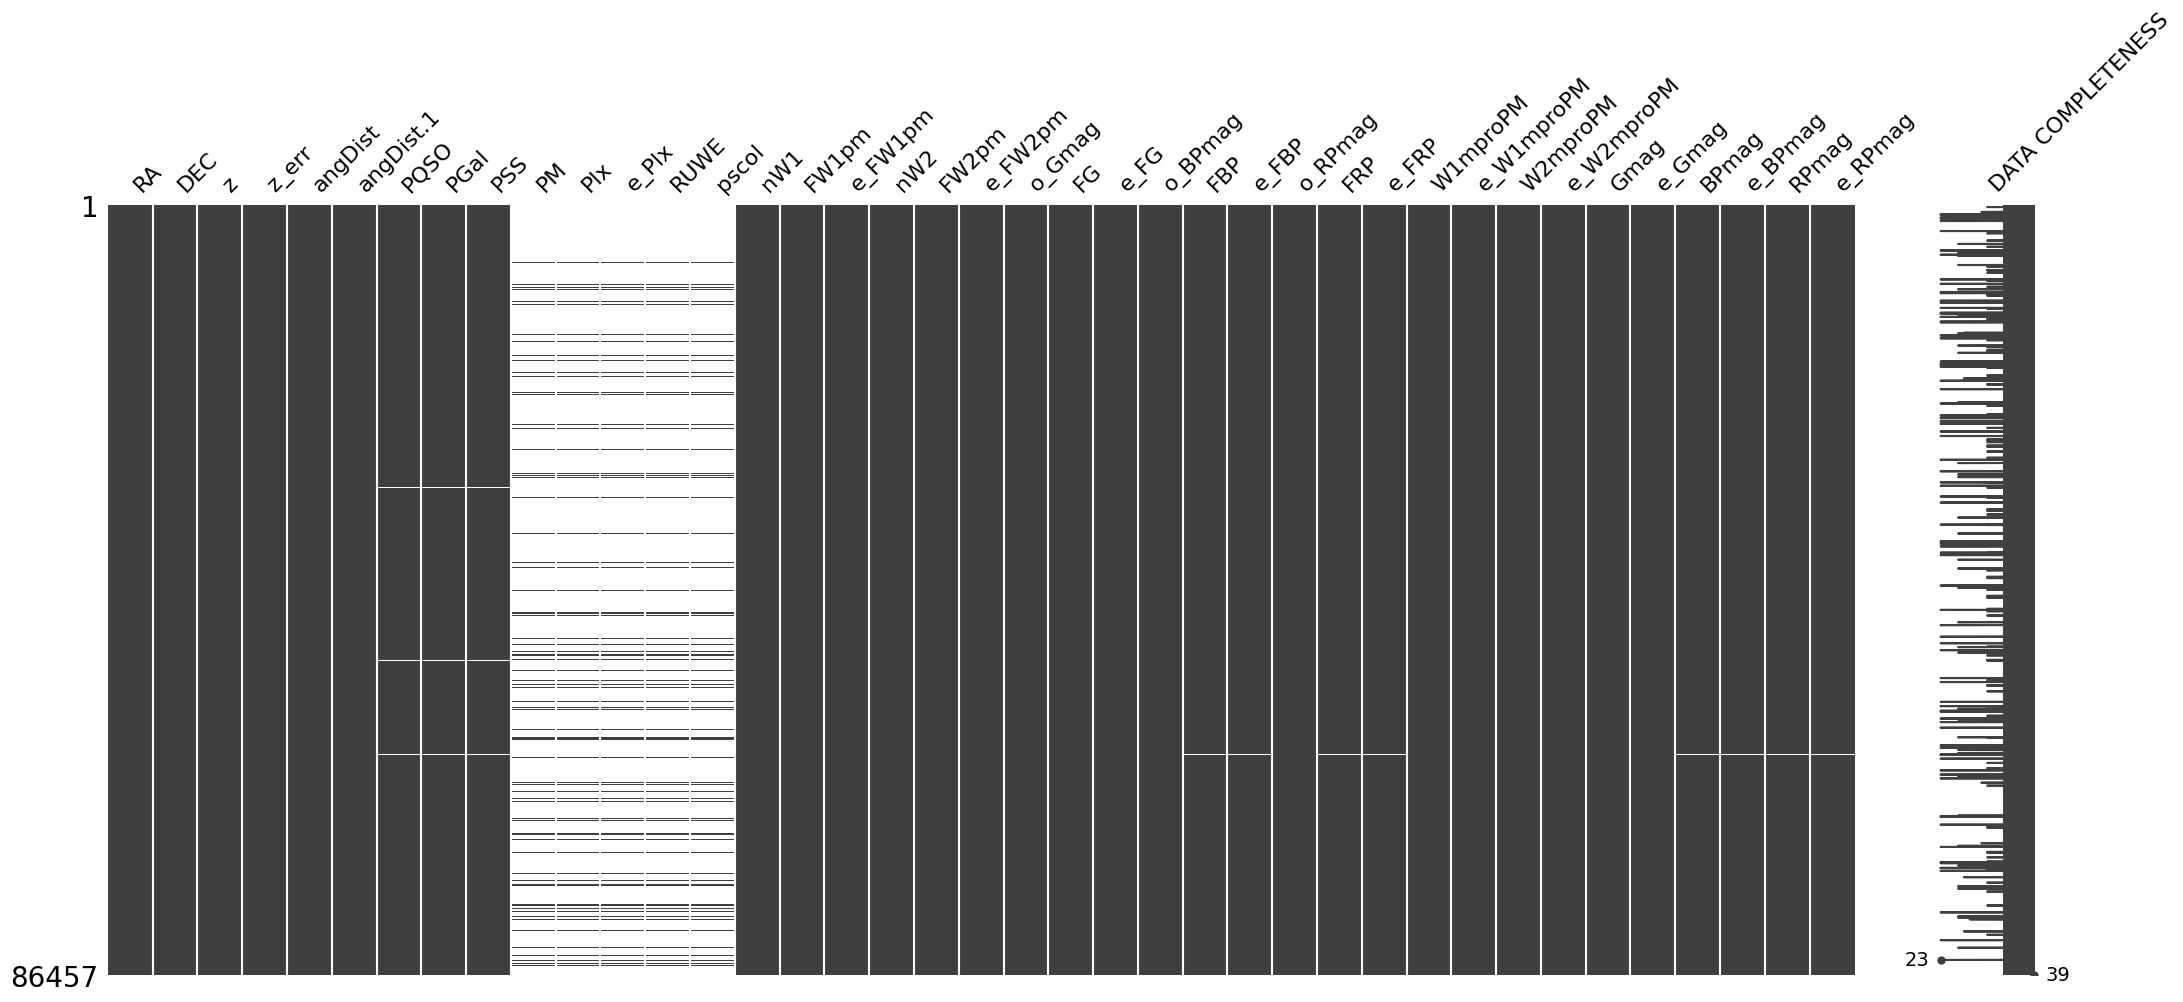

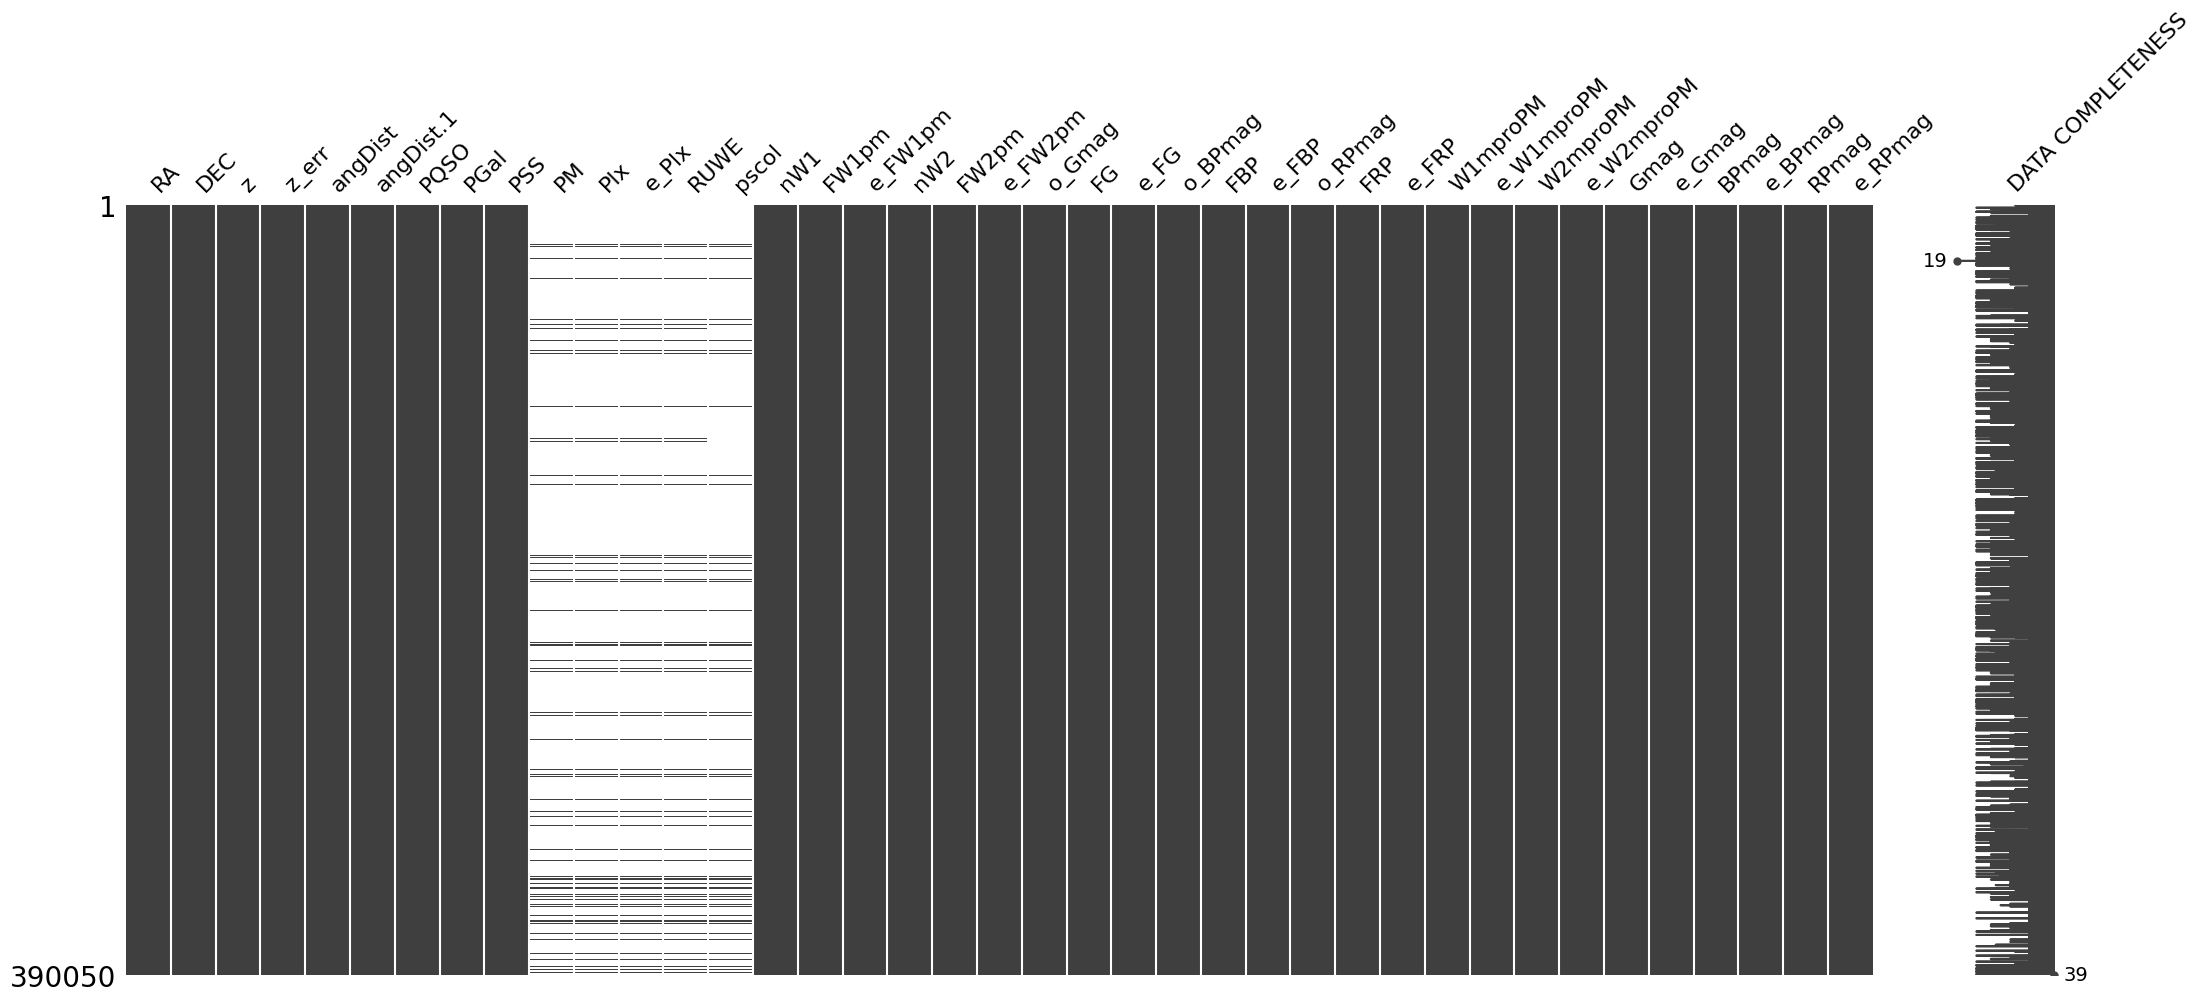

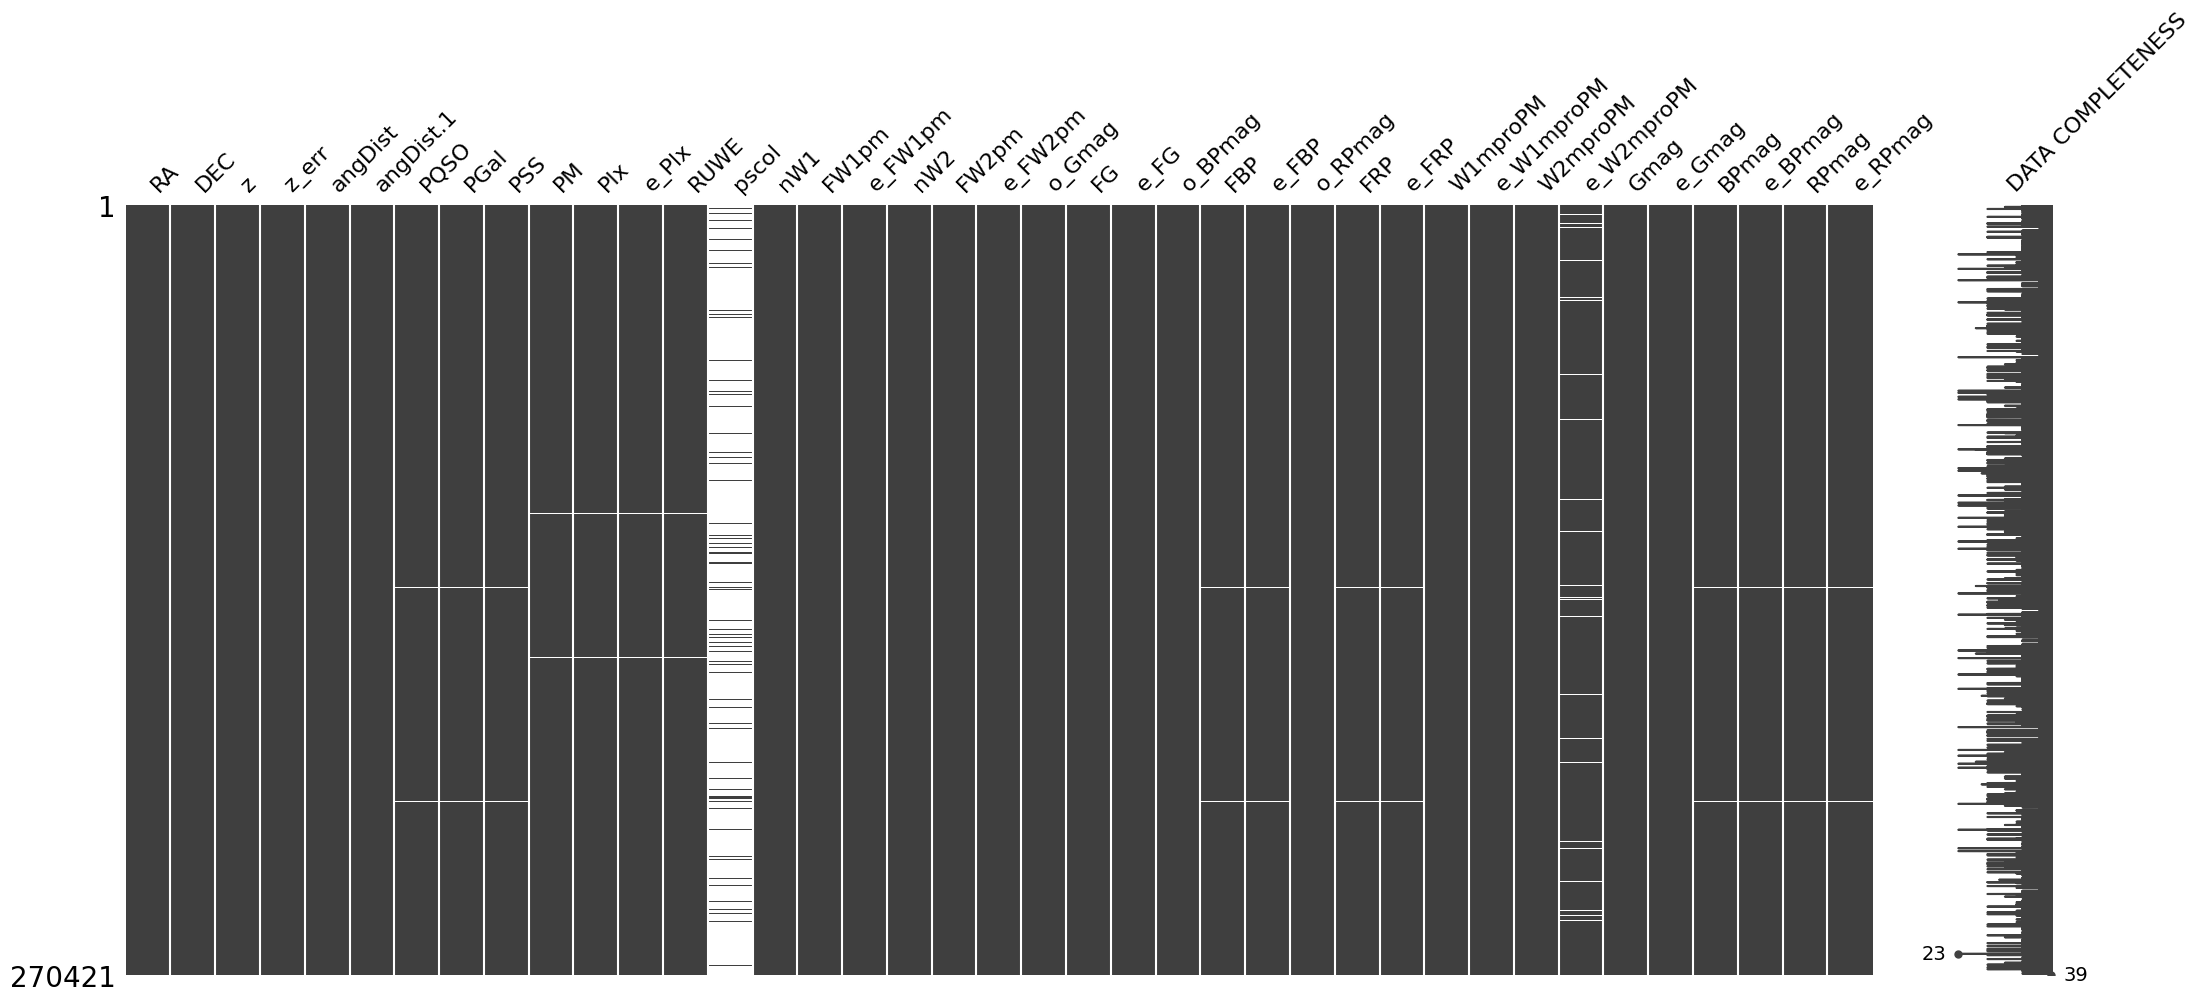

In [38]:
import missingno as msno

for name in config.name_class:
    data = pd.read_csv(f'/home/lrikozavr/ML_work/agn_sdss/sample/{name}.csv', header = 0, sep = ',')
    msno.matrix(data)

del data

Drop ["PM","Plx","e_Plx","RUWE","pscol"], because a lot of null value

In [47]:
for name in config.name_class:
    data = pd.read_csv(f'{config.path_sample}/{name}.csv', header = 0, sep = ',')
    data = data.drop(["PM","Plx","e_Plx","RUWE","pscol"], axis=1)
    data.to_csv(f'{config.path_sample}/{name}.csv', index=False)

Drop <b>NaN</b> data from sample and not zero <b>nW1&nW2</b>

In [40]:
columns = ['RA', 'DEC', 'z', 'z_err', 'angDist', 'angDist.1', 'PQSO', 'PGal', 'PSS', 
       'nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm',
       'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP', 
       'W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM',
       'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']

drop_stat = pd.DataFrame(np.zeros((len(config.name_class),len(columns))),columns=columns, index=config.name_class)

snr_stat = pd.DataFrame(np.zeros((len(config.name_class),2)),columns=["nW1","nW2"], index=config.name_class)

for name in config.name_class:
    data = pd.read_csv(f'{config.path_sample}/{name}.csv', header = 0, sep = ',')
    
    for cl in ["PQSO","PGal","PSS"]:
        data.loc[data[cl].fillna(9999.0) == 9999.0,cl] = 9999.0

    for name_ in data.columns.values:
        drop_stat.loc[name,name_] = data[data[name_].fillna("NaN") == "NaN"].shape[0]

    for nw in ["nW1","nW2"]:
        snr_stat.loc[name,nw] = data[data[nw] == 0].shape[0]
    
    data = data[(data["nW1"] > 0) & (data["nW2"] > 0)]

    data.dropna().reset_index(drop=True).to_csv(f'{config.path_sample}/{name}.csv', index=False)

del data

In [41]:
drop_stat

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,W1mproPM,e_W1mproPM,W2mproPM,e_W2mproPM,Gmag,e_Gmag,BPmag,e_BPmag,RPmag,e_RPmag
qso,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6.0,0.0,101.0,60.0,60.0,466.0,466.0,412.0,412.0
agn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,19.0,19.0,16.0,16.0
sbg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,15.0,4.0,4.0,74.0,74.0,70.0,70.0
sfg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,11.0,11.0,124.0,124.0,109.0,109.0
gal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,73.0,101.0,101.0,761.0,761.0,487.0,487.0
star,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,10135.0,7.0,7.0,386.0,386.0,380.0,380.0


In [42]:
snr_stat

,nW1,nW2
qso,178.0,1027.0
agn,7.0,8.0
sbg,28.0,128.0
sfg,40.0,49.0
gal,264.0,412.0
star,250.0,25762.0


<h1>Preprocessing pipeline<h1>

In [38]:
data = pd.read_csv(f'{config.path_ml_data}/{config.name_main_sample}_all.csv', header = 0, sep = ',')
data

,index,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,...,mcd_d,mcd_g,fuzzy_err,fuzzy_dist,qso_cls,agn_cls,sfg_cls,sbg_cls,gal_cls,star_cls
0,15099,190.261630,-7.332637,0.000291,0.000012,0.075495,0.086709,0.000000,0.0,0.999896,...,1.279861,0.298665,0.636398,0.812185,0,0,0,0,0,1
1,56011,332.999540,-0.368951,-0.000258,0.000009,0.471382,0.367904,0.000000,0.0,0.999990,...,0.426337,0.216552,0.691407,0.985426,0,0,0,0,0,1
2,67802,9.163182,0.008417,-0.000087,0.000009,0.056425,0.143701,0.000000,0.0,0.999977,...,0.689709,0.250108,0.680362,0.952098,0,0,0,0,0,1
3,197881,111.922690,15.704763,0.000033,0.000008,0.032151,0.055732,0.000000,0.0,0.999985,...,0.128384,0.175315,0.703636,0.984992,0,0,0,0,0,1
4,222265,9.098554,19.105056,-0.000114,0.000023,0.099534,0.156183,0.000000,0.0,0.999998,...,1.805111,0.295350,0.627709,0.689811,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096852,141349,359.445140,15.238241,0.167220,0.000026,0.014886,0.314018,0.000000,1.0,0.000000,...,1.074232,0.314482,0.684588,0.821716,0,0,0,0,1,0
1096853,133801,174.197160,20.709335,2.516286,0.000258,0.065945,0.210775,1.000000,0.0,0.000000,...,1.812916,0.413352,0.668916,0.600548,1,0,0,0,0,0
1096854,302755,138.932190,29.565420,-0.000073,0.000006,0.099392,0.064042,0.000000,0.0,0.999983,...,0.250147,0.192309,0.716292,0.972784,0,0,0,0,0,1
1096855,122851,49.146698,5.192355,-0.000006,0.000018,0.019941,0.326439,0.000001,0.0,0.999933,...,1.048945,0.285385,0.656945,0.859157,0,0,0,0,0,1


In [5]:
data = pd.read_csv(f'/media/lrikozavr/0402A64D02A64390/Users/lrik/Work/SDSS.csv', header = 0, sep = ',')
data

/tmp/ipykernel_21694/763466918.py:1: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f'/media/lrikozavr/0402A64D02A64390/Users/lrik/Work/SDSS.csv', header = 0, sep = ',')


,SURVEY,PLATEQUALITY,SOURCETYPE,RA,DEC,CLASS,SUBCLASS,z,z_err,ZWARNING,Z_NOQSO,Z_ERR_NOQSO,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,class_name
0,segue1,good,NONLEGACY,7.715366,-19.702714,STAR,F5,0.000248,0.000022,0,0.0,0.0,0,NaN,NaN,star
1,segue1,good,NONLEGACY,7.487451,-19.669474,STAR,F9,0.000093,0.000010,0,0.0,0.0,0,NaN,NaN,star
2,segue1,good,NONLEGACY,7.259242,-19.656897,STAR,M0,0.000038,0.000008,0,0.0,0.0,0,NaN,NaN,star
3,segue1,good,NONLEGACY,7.679973,-19.641483,STAR,F5,-0.000613,0.000022,0,0.0,0.0,0,NaN,NaN,star
4,segue1,good,NONLEGACY,8.139904,-19.639879,STAR,G2,-0.000164,0.000014,0,0.0,0.0,0,NaN,NaN,star
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854986,segue1,good,NONLEGACY,98.019854,84.791898,STAR,F5,-0.000761,0.000009,0,0.0,0.0,0,NaN,NaN,star
4854987,segue1,good,NONLEGACY,97.666877,84.793093,STAR,F2,-0.000391,0.000023,0,0.0,0.0,0,NaN,NaN,star
4854988,segue1,good,NONLEGACY,92.883648,84.794836,STAR,F9,-0.000158,0.000009,0,0.0,0.0,0,NaN,NaN,star
4854989,segue1,good,NONLEGACY,94.478598,84.837773,STAR,F9,-0.000321,0.000017,0,0.0,0.0,0,NaN,NaN,star


In [6]:
one_hot_layer = lambda x: np.array([1 if x==class_name else 0 for i, class_name in enumerate(config.name_class)])
data = pd.concat([data,pd.DataFrame(np.array(np.resize(np.concatenate(data.loc[:,"class_name"].apply(one_hot_layer).values,axis=0),(4854991,6))),columns=config.name_class_cls)],axis = 1)

data

,SURVEY,PLATEQUALITY,SOURCETYPE,RA,DEC,CLASS,SUBCLASS,z,z_err,ZWARNING,...,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,class_name,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
0,segue1,good,NONLEGACY,7.715366,-19.702714,STAR,F5,0.000248,0.000022,0,...,0,NaN,NaN,star,0,0,0,0,0,1
1,segue1,good,NONLEGACY,7.487451,-19.669474,STAR,F9,0.000093,0.000010,0,...,0,NaN,NaN,star,0,0,0,0,0,1
2,segue1,good,NONLEGACY,7.259242,-19.656897,STAR,M0,0.000038,0.000008,0,...,0,NaN,NaN,star,0,0,0,0,0,1
3,segue1,good,NONLEGACY,7.679973,-19.641483,STAR,F5,-0.000613,0.000022,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4,segue1,good,NONLEGACY,8.139904,-19.639879,STAR,G2,-0.000164,0.000014,0,...,0,NaN,NaN,star,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854986,segue1,good,NONLEGACY,98.019854,84.791898,STAR,F5,-0.000761,0.000009,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854987,segue1,good,NONLEGACY,97.666877,84.793093,STAR,F2,-0.000391,0.000023,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854988,segue1,good,NONLEGACY,92.883648,84.794836,STAR,F9,-0.000158,0.000009,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854989,segue1,good,NONLEGACY,94.478598,84.837773,STAR,F9,-0.000321,0.000017,0,...,0,NaN,NaN,star,0,0,0,0,0,1


In [25]:
data_temp = data[0.1 <= abs(data["z_err"]/data["z"])]

In [26]:
data_temp

,SURVEY,PLATEQUALITY,SOURCETYPE,RA,DEC,CLASS,SUBCLASS,z,z_err,ZWARNING,...,ZWARNING_NOQSO,CLASS_NOQSO,SUBCLASS_NOQSO,class_name,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
1,segue1,good,NONLEGACY,7.487451,-19.669474,STAR,F9,0.000093,0.000010,0,...,0,NaN,NaN,star,0,0,0,0,0,1
2,segue1,good,NONLEGACY,7.259242,-19.656897,STAR,M0,0.000038,0.000008,0,...,0,NaN,NaN,star,0,0,0,0,0,1
5,segue1,good,NONLEGACY,7.754850,-19.633693,STAR,F9,-0.000053,0.000010,0,...,0,NaN,NaN,star,0,0,0,0,0,1
6,segue1,good,NONLEGACY,8.247421,-19.625737,STAR,K1,0.000030,0.000007,0,...,0,NaN,NaN,star,0,0,0,0,0,1
8,segue1,good,NONLEGACY,7.365562,-19.614238,STAR,F9,-0.000071,0.000008,0,...,0,NaN,NaN,star,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4854966,segue1,good,NONLEGACY,87.383295,84.662072,STAR,A0,-0.000247,0.000091,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854967,segue1,good,NONLEGACY,91.447261,84.669439,STAR,A0,-0.000260,0.000060,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854972,segue1,good,NONLEGACY,88.017529,84.703149,STAR,F5,-0.000037,0.000009,0,...,0,NaN,NaN,star,0,0,0,0,0,1
4854974,segue1,good,NONLEGACY,95.203985,84.718747,STAR,K1,-0.000014,0.000008,0,...,0,NaN,NaN,star,0,0,0,0,0,1


In [28]:
def count(data,col):
    print(col)
    for i in data[col].unique():
        print("\t",i,"\t\t",data[data[col] == i].shape[0])

count(data_temp,"PLATEQUALITY")
count(data_temp,"CLASS")
#count(data,"SUBCLASS")
count(data_temp,"CLASS_NOQSO")
count(data_temp,"agn_cls")


PLATEQUALITY
	 good 		 530602
	 bad 		 16429
	 marginal 		 46697
CLASS
	 STAR 		 579360
	 QSO 		 11831
	 GALAXY 		 2537
CLASS_NOQSO
	 nan 		 0
	 STAR 		 283978
	 GALAXY 		 8806
agn_cls
	 0 		 593722
	 1 		 6


In [19]:
from matplotlib import pyplot as plt
%matplotlib inline
def Hist1(ax,x,mag,label, **kwargs):
    ax.set_xlabel(mag,fontsize=40)
    ax.set_ylabel("count",fontsize=40)
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.set_yscale('log')
    #ax.set_title(name,fontsize = 50)
    ax.hist(x,bins=50, label=label,**kwargs)

In [33]:
config.name_class

['qso', 'agn', 'sfg', 'sbg', 'gal', 'star']

In [29]:
columns = "z_err"
def diff(data):
    mass_data_class = []
    count = np.zeros(len(config.name_class))
    for i, name_class in enumerate(config.name_class):
        if(name_class == "qso"):
            count[i] = data[((data[f"{name_class}_cls"] == 1)) & (data["z"] <= 4.0)].loc[:,[columns]].shape[0]
        #elif(not name_class == "star"):
        else:
            count[i] = data[(data[f"{name_class}_cls"] == 1)].loc[:,[columns]].shape[0]
    print(count)
    for i, name_class in enumerate(config.name_class):
        if(name_class == "qso"):
            mass_data_class.append(data[((data[f"{name_class}_cls"] == 1)) & (data["z"] <= 4.0)].loc[:,[columns]])
        #elif(not name_class == "star"):
        else:
            mass_data_class.append(data[(data[f"{name_class}_cls"] == 1)].loc[:,[columns]])
    return mass_data_class

mass_data_class = diff(data_temp)    

[1.1387e+04 6.0000e+00 8.0000e+00 9.0000e+00 2.5140e+03 5.7936e+05]


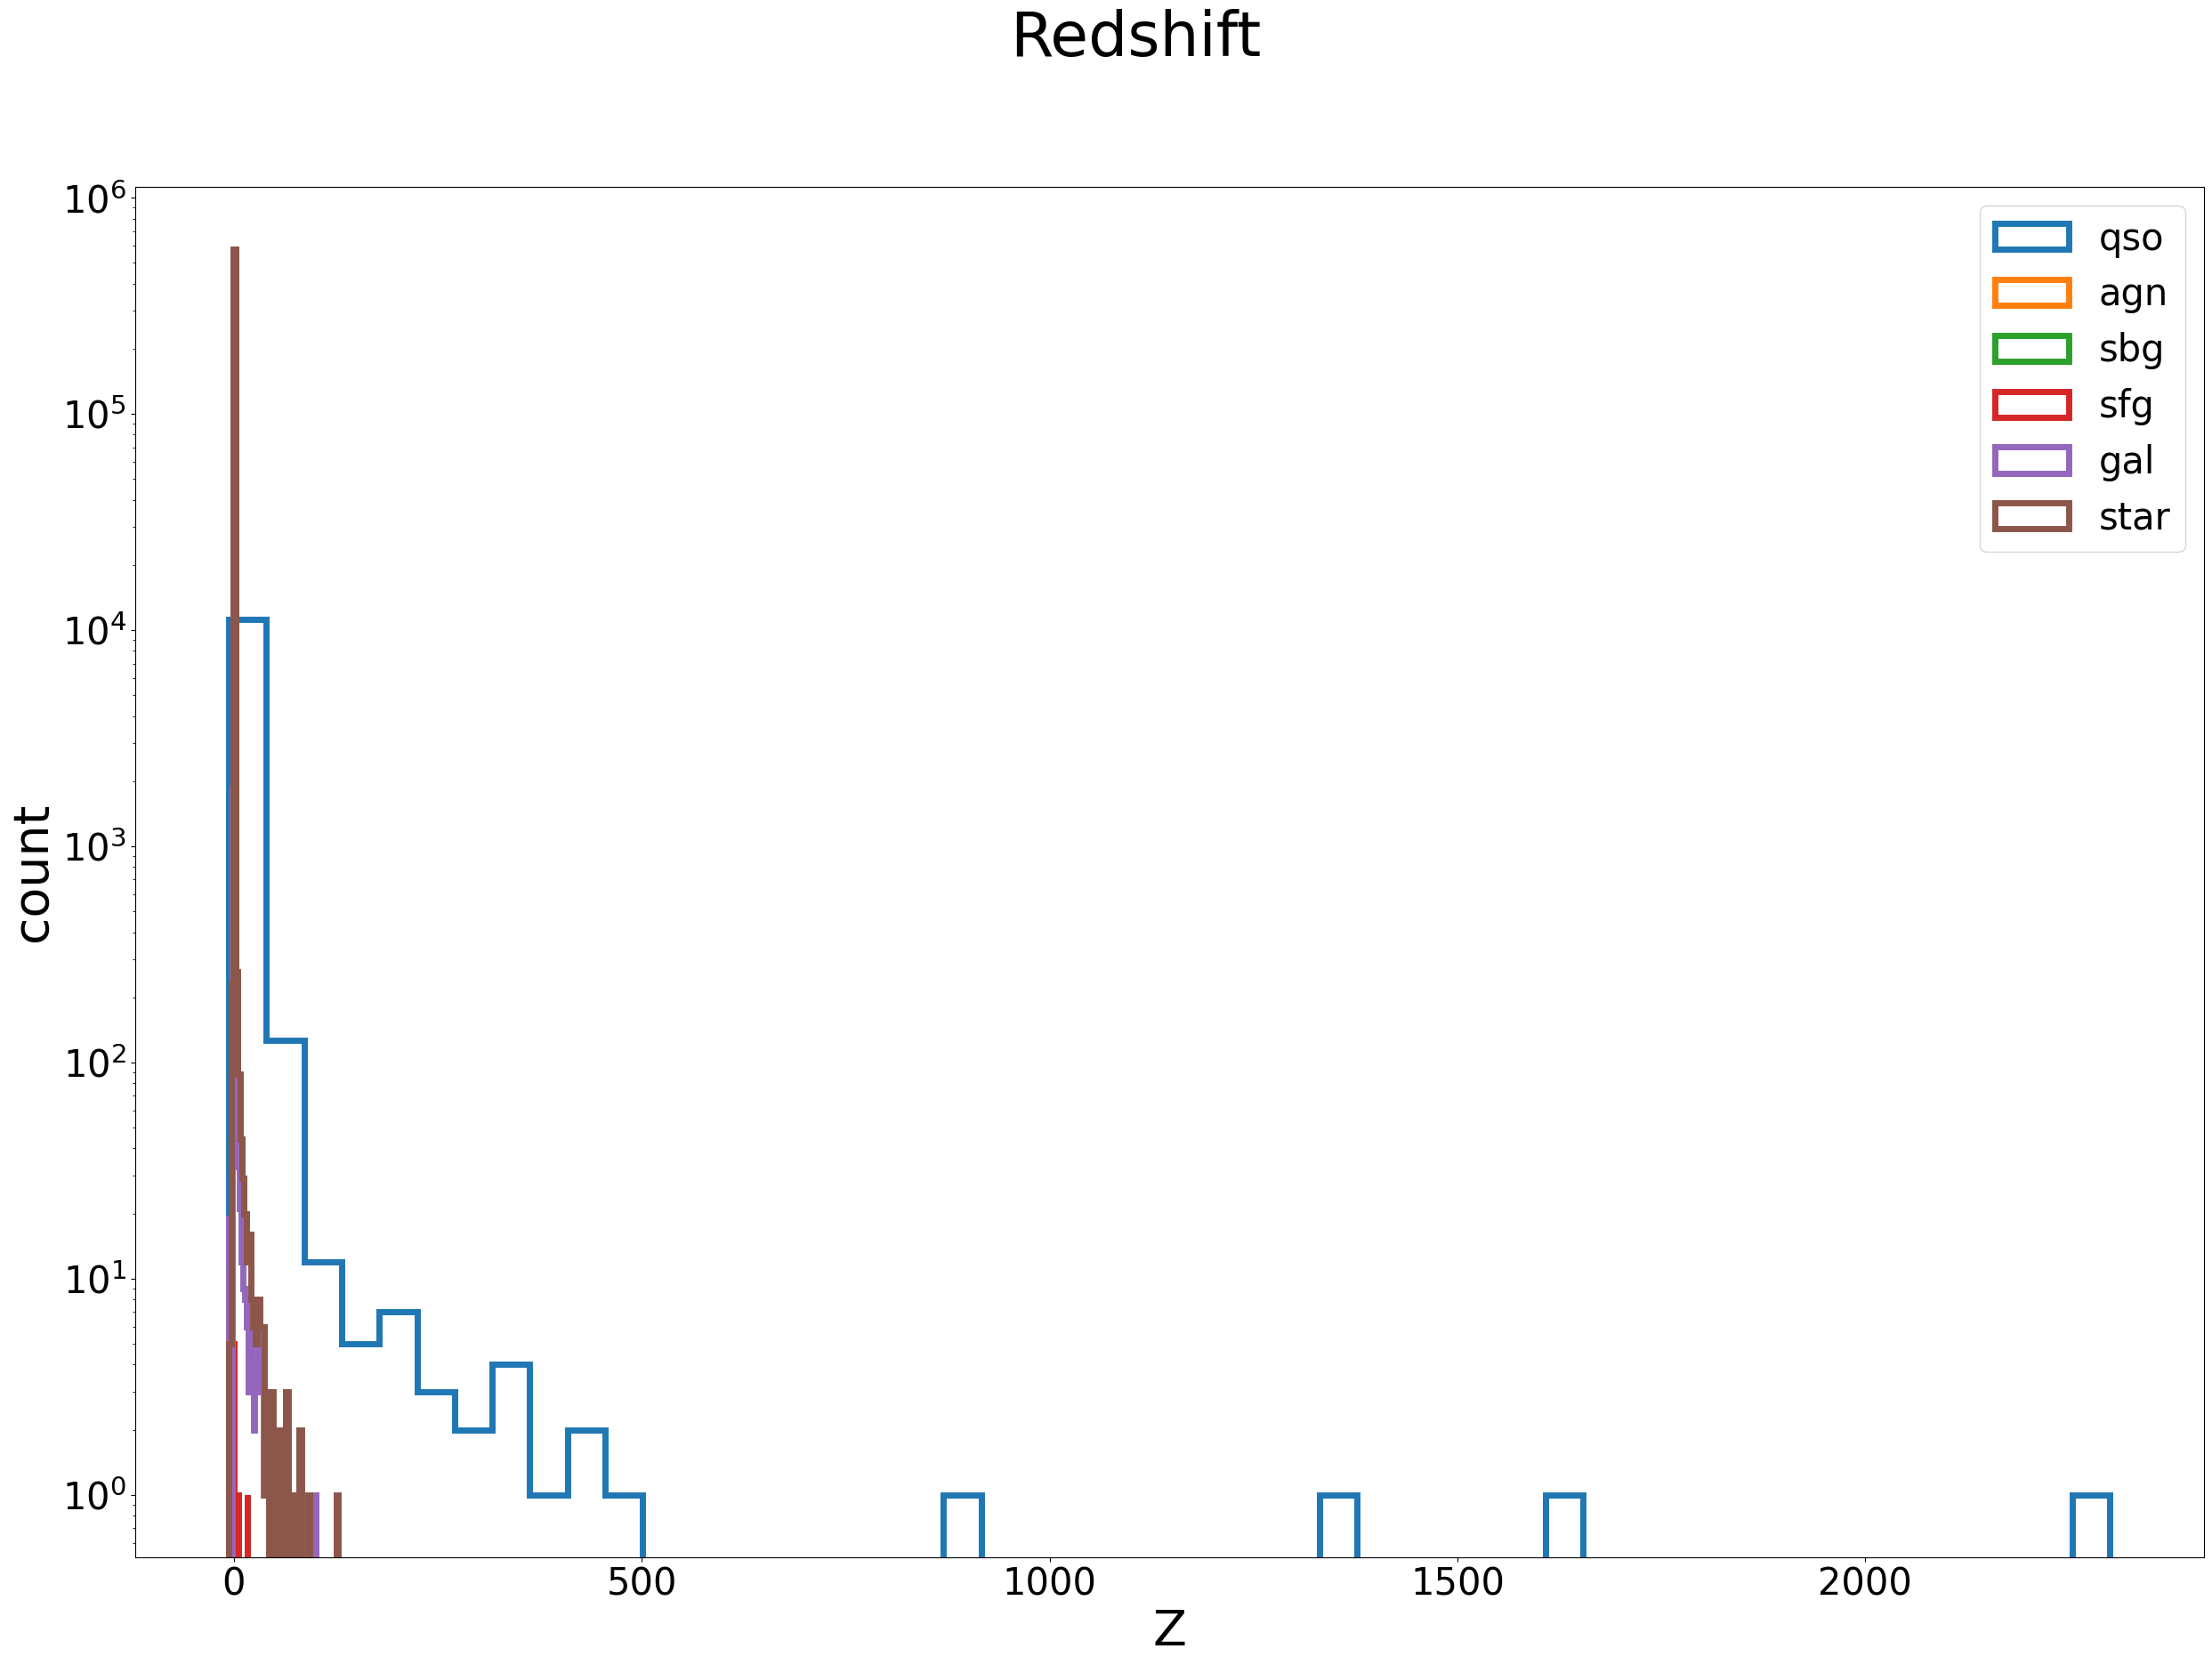

In [30]:

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
fig.suptitle("Redshift", fontsize=50)       
for i, name_class in enumerate(config.name_class):
    #if(not name_class == "star"):
    Hist1(ax,mass_data_class[i],'Z',name_class, histtype='step', fill=config.picture["hist"]["fill"], lw=5)
ax.legend(prop={'size': 30})
fig.set_size_inches(30,20)
#fig.savefig(f"{config.path_pic}/hist/{config.name_sample}_{class_name}_{col}_hist.png")
#fig.show()
plt.show()
#plt.close(fig)

<h1>Processing pipline</h1>

In [4]:
data = pd.DataFrame()
#data preparation
if(not config.flags['data_preprocessing']['work']):
    if(os.path.isfile(f'{config.path_ml_data}/{config.name_main_sample}_all.csv')):
        data = pd.read_csv(f'{config.path_ml_data}/{config.name_main_sample}_all.csv', header = 0, sep = ',')
    else:
        data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)
else:
    data = data_preparation(config.path_ml_data,config.path_sample,config.name_class,config)

read data qso
               RA        DEC         z     z_err   angDist  angDist.1   
0       166.53116 -17.520444  2.546282  0.000149  0.063532   0.069244  \
1       166.95578 -17.279537  2.706933  0.000162  0.037483   0.526276   
2         8.29727 -17.178208  2.906453  0.000079  0.047789   0.054932   
3       168.08451 -16.924625  2.807152  0.000094  0.082540   0.157929   
4       167.30094 -16.592488  2.311591  0.000203  0.141427   0.157660   
...           ...        ...       ...       ...       ...        ...   
387427  183.49273  67.869849  2.347018  0.000507  0.268947   0.245011   
387428  188.67065  67.870509  0.274328  0.000031  0.074282   0.120631   
387429  181.60952  67.874351  1.209410  0.000530  0.018842   0.125109   
387430  150.91964  67.875852  0.654613  0.000132  0.087496   0.039498   
387431  179.29461  67.878838  0.904611  0.000177  0.204578   0.227457   

            PQSO      PGal       PSS  nW1  ...  W1mproPM  e_W1mproPM   
0       0.999891  0.000000  0.000109 

In [5]:
data

,RA,DEC,z,z_err,angDist,angDist.1,PQSO,PGal,PSS,nW1,...,mcd_d,mcd_g,fuzzy_err,fuzzy_dist,qso_cls,agn_cls,sbg_cls,sfg_cls,gal_cls,star_cls
0,143.148690,9.761399,0.000173,0.000008,0.088343,0.129133,0.000000,0.000000,0.999986,12,...,0.722900,0.253492,0.708120,0.919953,0,0,0,0,0,1
1,202.178650,42.284748,2.017180,0.000385,0.219786,0.372749,1.000000,0.000000,0.000000,12,...,0.959227,0.294686,0.620386,0.943378,1,0,0,0,0,0
2,171.555040,5.305385,0.169591,0.000049,0.031265,0.177329,0.000000,0.001574,0.995552,13,...,1.519506,0.376366,0.653349,0.918495,0,0,0,0,1,0
3,200.550010,1.907388,0.581355,0.000186,0.076426,0.011496,1.000000,0.000000,0.000000,13,...,1.320702,0.377015,0.701765,0.912289,1,0,0,0,0,0
4,180.312780,56.308382,0.092691,0.000033,0.126665,0.076625,0.000000,1.000000,0.000000,12,...,0.900055,0.282182,0.686718,0.933920,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901747,254.324790,17.324851,2.440358,0.000595,0.036355,0.166234,1.000000,0.000000,0.000000,12,...,1.396401,0.389799,0.681912,0.885654,1,0,0,0,0,0
901748,27.508198,30.290029,1.628824,0.000264,0.021590,0.209047,0.999998,0.000002,0.000000,13,...,1.404779,0.391088,0.667945,0.907110,1,0,0,0,0,0
901749,179.974180,5.161094,0.167510,0.000043,0.056863,0.481544,0.000000,1.000000,0.000000,12,...,1.055430,0.313570,0.669434,0.980306,0,0,0,0,1,0
901750,271.505230,78.177268,-0.000222,0.000008,0.180226,0.176059,0.000000,0.000000,0.999961,12,...,0.629579,0.243769,0.710078,0.964582,0,0,0,0,0,1


Basic statistic from sample

In [12]:
#data_statistic
if(config.statistic["metric"]):
    data.describe().transpose().to_csv(f'{config.path_stat}/{config.name_main_sample}_stat.log')

<h1>Machine Learning</h1>

In [16]:
#network training
if(config.hyperparam["model_variable"]["work"]):
    #features from config
    #name from config
    print('Sample name: ', config.name_sample)
    print('Features: ', config.features["data"])
    #hyperparams from config
    batch_size = config.hyperparam['batch_size']
    num_ep = config.hyperparam['num_ep']
    optimizer = config.hyperparam['optimizer']
    loss = config.hyperparam['loss']
    validation_split = config.hyperparam['validation_split']
    #balanced class
    class_weights = None
    if(config.hyperparam["model_variable"]["balanced"]):
        from sklearn.utils import class_weight
        y = np.zeros(data.shape[0])
        cl = np.array(data[config.name_class_cls].values)
        #print(cl)
        for i in range(data.shape[0]):
            y[i] = np.argmax(cl[i,:])
        class_weights = dict(enumerate(class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(y),y = y)))
        print("class weights",class_weights)
        del y

    print(data)

    print("Features mode list:\t",config.features["train"])
    features = get_features(config.features["train"],config)
    print("Features train values:\t",features)
    
    sample_weight = None
    if(config.hyperparam["model_variable"]["sample_weight"] in config.flags['data_preprocessing']['main_sample']['weight']['method']):
        #sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values
        sample_weight = data[config.hyperparam["model_variable"]["sample_weight"]].values.T[0]
        print(sample_weight)

    try:
        data[features]
    except:
        raise Exception("data don't have initiated features, check config.features['train'] value and WARNINGs above")

    if(config.hyperparam["model_variable"]["work"]):
        NN(data[features],data[config.name_class_cls],data['z'],sample_weight,validation_split,batch_size,num_ep,optimizer,loss,class_weights,
        output_path_predict = config.path_predict,
        output_path_mod = config.path_model,
        output_path_weight = config.path_weight,
        path_save_eval = config.path_eval,
        config=config)

Sample name:  agn_sdss_diploma_sample_QSO_GAL_MCDcutderedded_weightbalanced_outlire
Features:  {'astrometry': ['angDist', 'PQSO', 'PGal', 'PSS'], 'flux': ['nW1', 'FW1pm', 'e_FW1pm', 'nW2', 'FW2pm', 'e_FW2pm', 'o_Gmag', 'FG', 'e_FG', 'o_BPmag', 'FBP', 'e_FBP', 'o_RPmag', 'FRP', 'e_FRP'], 'photometry': ['W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM', 'Gmag', 'e_Gmag', 'BPmag', 'e_BPmag', 'RPmag', 'e_RPmag']}
class weights {0: 0.4186604936724023, 1: 11.470045027856216, 2: 13.300176991150442, 3: 3.1169272885644363, 4: 0.6417387220051667, 5: 0.6369573601522337}
                RA        DEC         z     z_err   angDist  angDist.1   
0       143.148690   9.761399  0.000173  0.000008  0.088343   0.129133  \
1       202.178650  42.284748  2.017180  0.000385  0.219786   0.372749   
2       171.555040   5.305385  0.169591  0.000049  0.031265   0.177329   
3       200.550010   1.907388  0.581355  0.000186  0.076426   0.011496   
4       180.312780  56.308382  0.092691  0.000033  0.126665   0

<h1>Metric statistic<h1>

In [18]:
#statistic
from statistic import metric_statistic
if(config.statistic["metric"]):
    metric_statistic(config)

make metrics stat


In [ ]:
print(data)

In [11]:
from graphic import picture_confusion_matrix, picture_roc_prc, picture_hist, TSNE_pic, contam_dist_pic, multigridplot, picture_correlation_matrix


In [15]:
picture_correlation_matrix(data[get_features(config.features["train"],config)],"mags",config)

['var', 'color']


In [ ]:
TSNE_pic(data,config)

In [ ]:
contam_dist_pic(data,config)

In [26]:
multigridplot(data,get_features(config.features["train"],config),config)
















['color']
picture Multigrid plot: start
Features  qso_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  agn_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  sfg_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  sbg_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  gal_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
Features  star_cls
Progress: |██████████████████████████████████████████████████| 100.00% 
picture Multigrid plot: done


In [5]:
fconfig = open('config_agn_sdss.json')
config = Config(fconfig)
fconfig.close()
del fconfig

In [6]:
picture_roc_prc(config)

/home/lrikozavr/github/extragalactic_object_locate_with_ml/export/graphic.py:612: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(f'{config.path_pic}/roc_prc/{config.name_sample}_class_kfold_summary_roc_prc.png')


picture ROC&PRC done


In [17]:
picture_confusion_matrix(config)

picture Confusion Matrix done


In [ ]:
picture_hist(data,config)

In [22]:
from graphic import redshift_estimation

redshift_estimation(config)